# Train on Real, Test on Synthetic
**TRTS (Train on Real, Test on Synthetic)**: The classification model is trained excusively on real ECG data from the MIT-BIH Arrhythmia dataset, then evaluated on synthetic data generated by the GAN. This approach evaluates how well the model generalizes to a "new domain" (the synthetic distribution).
* If the model performs well on the synthetic data, it suggests that the synthetic data is quite realistic and similar to the real data from the model's point of view.
* If the performance drops, it may indicate that the synthetic data does not closely match the real data distribution, or that the model has overfitted to real data characteristics that are not present in the synthetic data.

# 1. Setup and Imports
* All the necessary packages are imported and the Google drive is mounted to access stored files.
* A local utility file is imported. It contains helper functions for ECG data processing and for building a test model.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
import glob
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from google.colab import drive

In [3]:
# Mount drive to access database and synthetic files
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Imports local libraries
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Masters_Code/Utils')

from ECGUtils import ECGUtils

# 2. Loading and Processing the Real Data
* The heartbeat classes that we are interested are defined and the data is loaded from the MIT-BIH dataset. This real data will be used exclusively for training.

In [5]:
# Target classes
heartbeat_classes = ['N', 'L', 'R', 'V', 'A']

# List of records in the MIT-BIH dataset
record_files = glob.glob('/content/drive/My Drive/Colab Notebooks/Datasets/mitbih_data/*.dat')
record_names = [os.path.basename(f).split('.')[0] for f in record_files]

# Exclude records with paced beats
excluded_records = ['102', '104', '107', '217']
record_names = [rec for rec in record_names if rec not in excluded_records]

# Extract segments and labels using the utility function
segments, labels = ECGUtils.extract_heartbeat_segments(record_names, heartbeat_type=heartbeat_classes, max_segments=-1)

print("Real data collection completed.")
print("Total number of samples (real):", len(segments))

100%|██████████| 44/44 [00:36<00:00,  1.20it/s]

Real data collection completed.
Total number of samples (real): 95801


## 2.1 Encoding Labels and Normalizing
* The string labels are encoded into integers and then into one-hot vectors.
* The real ECG data is also normalized so that each feature has zero mean and unit variance.

In [6]:
# Convert lists to numpy arrays
real_segments = np.array(segments)
real_labels = np.array(labels)

print("Real data shape:", real_segments.shape)
print("Real labels shape:", real_labels.shape)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(real_labels)
print("Encoded labels:", np.unique(integer_encoded))

# Convert labels to one-hot encoding
one_hot_labels = to_categorical(integer_encoded)
print("One-hot labels shape:", one_hot_labels.shape)

# Normalize each Segment
scaler = StandardScaler()
real_segments_normalized = scaler.fit_transform(real_segments)

# Reshape data for the model
real_segments_normalized = real_segments_normalized.reshape(-1, 256, 1)
print("Real data normalized shape:", real_segments_normalized.shape)

Real data shape: (95801, 256)
Real labels shape: (95801,)
Encoded labels: [0 1 2 3 4]
One-hot labels shape: (95801, 5)
Real data normalized shape: (95801, 256, 1)


## 2.2. Splitting Real Data into Train and Validation
* We allocate the real data into training and validation sets. There is no test set, since this one is going to be made of synthetic data only.

In [7]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    real_segments_normalized, one_hot_labels, test_size=0.2, random_state=42, stratify=one_hot_labels)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (76640, 256, 1)
Validation set shape: (19161, 256, 1)


# Loading Synthetic (GAN-Generated) Test Data
* The synthetic ECG segments are loaded from pre-generated `.npy` files that contain the generated data from the developed GAN.
* These will serve as the test set.

In [8]:
# Define the path to your synthetic data files
synthetic_data_files = {
    'N': '/content/drive/My Drive/Colab Notebooks/Generated Data/generated_heartbeats_N.npy',
    'L': '/content/drive/My Drive/Colab Notebooks/Generated Data/generated_heartbeats_L.npy',
    'R': '/content/drive/My Drive/Colab Notebooks/Generated Data/generated_heartbeats_R.npy',
    'V': '/content/drive/My Drive/Colab Notebooks/Generated Data/generated_heartbeats_V.npy',
    'A': '/content/drive/My Drive/Colab Notebooks/Generated Data/generated_heartbeats_A.npy'
}

# Load the synthetic data from the files
synthetic_segments, synthetic_labels = ECGUtils.load_synthetic_data(synthetic_data_files)

Synthetic data loaded.
Synthetic data shape: (10000, 256)
Synthetic labels shape: (10000,)


## 3.2. Encoding Labels and Normalizing
* We use the same scaler that was fitted on the real data to ensure consistent normalization. We then one-hot encode synthetic labels and reshape the data.

In [9]:
# Encode labels using the same label encoder
synthetic_integer_encoded = label_encoder.transform(synthetic_labels)
synthetic_one_hot_labels = to_categorical(synthetic_integer_encoded)
print("Synthetic one-hot labels shape:", synthetic_one_hot_labels.shape)

# Normalize synthetic data using the scaler fitted on real data
synthetic_segments_normalized = scaler.transform(synthetic_segments)

# Reshape data for the model (samples, timesteps, channels)
synthetic_segments_normalized = synthetic_segments_normalized.reshape(-1, 256, 1)
print("Synthetic data normalized shape:", synthetic_segments_normalized.shape)

Synthetic one-hot labels shape: (10000, 5)
Synthetic data normalized shape: (10000, 256, 1)


# 4. Classification Model
* The classification model is created using a helper function from `ECGUtils`.
* It is trained on real data.


In [10]:
model = ECGUtils.build_test_model()
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,285 (5.02 KB)

 Trainable params: 1,285 (5.02 KB)

 Non-trainable params: 0 (0.00 B)

## 4.1 Training the Model on Real Data Only
* The model is trained using only the real training set, monitoring performance on the validation set.
* Early stopping and model checkpoints help to selecte the best model before testing it on the synthetic data

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/model_real.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/50
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6693 - loss: 1.0982 - val_accuracy: 0.8668 - val_loss: 0.5654
Epoch 2/50
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8699 - loss: 0.5198 - val_accuracy: 0.8863 - val_loss: 0.4262
Epoch 3/50
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8858 - loss: 0.4105 - val_accuracy: 0.8822 - val_loss: 0.3801
Epoch 4/50
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8859 - loss: 0.3761 - val_accuracy: 0.8953 - val_loss: 0.3585
Epoch 5/50
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8904 - loss: 0.3611 - val_accuracy: 0.8944 - val_loss: 0.3467
Epoch 6/50
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8891 - loss: 0.3497 - val_accuracy: 0.8877 - val_loss: 0.3470
Epoch 7/50
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8910 - loss: 0.3459 - val_accuracy: 0.8942 - val_loss: 0.3346
Epoch 8/50
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8937 - loss: 0.3400 - 

## 4.2. Evaluating the Model on Synthetic Test Set (TRTS)
* The real-trained model is tested on the synthetic dataset. This will reveal how well the model generalizes to synthetic data and how realistic the synthetic data is from the model's perspective.
* A high accuracy here suggests the synthetic data is similar enough to the real data distribution. A low accuracy would indicate a potential mismatch between real and synthetic distributions.

In [12]:
# Load the best model
model.load_weights('/content/drive/My Drive/Colab Notebooks/model_real.keras')

# Evaluate on synthetic test data
test_loss, test_accuracy = model.evaluate(synthetic_segments_normalized, synthetic_one_hot_labels)
print("Test Accuracy on synthetic data:", test_accuracy)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9169 - loss: 0.2994
Test Accuracy on synthetic data: 0.7542999982833862


## 4.3 Confusion matric and report
* The confusion matrix is examined to see how the model's predictions are distributed acress synthetic classes. This can help identify which classes are harder for the model to recognize in synthetic form.

In [13]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions
y_pred_probs = model.predict(synthetic_segments_normalized)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(synthetic_one_hot_labels, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix for color intensity
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix_normalized = np.nan_to_num(conf_matrix_normalized)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           A       0.95      0.34      0.50      2000
           L       0.87      0.88      0.88      2000
           N       0.50      1.00      0.67      2000
           R       0.95      0.91      0.93      2000
           V       0.93      0.64      0.76      2000

    accuracy                           0.75     10000
   macro avg       0.84      0.75      0.75     10000
weighted avg       0.84      0.75      0.75     10000



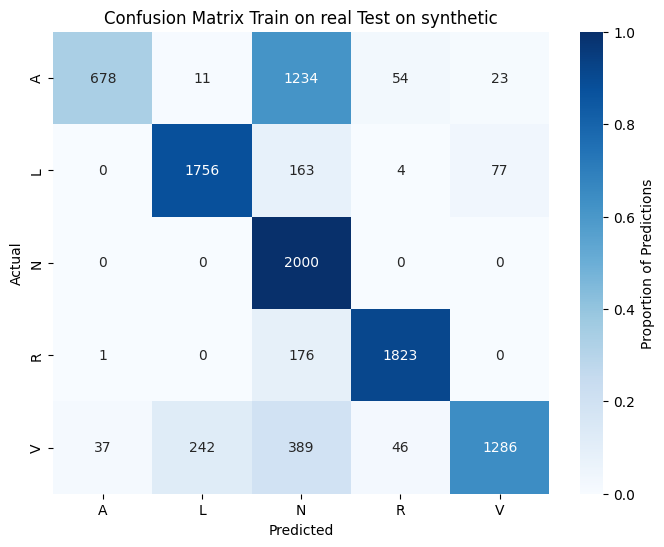

In [14]:
# Plot confusion matrix with normalized colors and actual counts
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=conf_matrix, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Proportion of Predictions'})

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Train on real Test on synthetic')
plt.show()
